# MNIST handwritten digits classification with MLPs, by hand

Author: Bethany Lusch adapting notebooks by Tanwi Mallick, Prasanna Balaprakash and Taylor Childers

## Goal of notebook:

In this notebook, we'll train a multi-layer perceptron model (a basic kind of neural network) to classify handwritten digits. We'll build up the code by hand. Next week, we show how this can be done using existing Python libraries.

## Machine learning task:

This tutorial works through a supervised learning problem, specifically classification.

Imagine you are making a machine for the post office that will automatically sort mail by zip code. The MNIST dataset contains thousands of examples of handwritten numbers, with each digit labeled 0-9. We will use deep learning to create a function that classifies each image of one number as a digit 0-9.
<img src="images/mnist_task.png"  align="left"/>

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt

2024-04-09 05:04:28.235035: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## MNIST data set

Next we'll load the MNIST handwritten digits data set. The first time we may have to download the data, which can take a while.

<img src="images/MnistExamples.png"  align="left"/>

MNIST is a popular dataset, so we can download it via the TensorFlow library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

In [3]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
import numpy as np
import tensorflow as tf

# Define the path to the local MNIST dataset file
mnist_path = "mnist.npz"

# Load the MNIST dataset from the local file
with np.load(mnist_path, allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

# Display some information about the dataset
print("Training images shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


We do some pre-processing on the images: convert from integer to float32 and normalize the pixels to be within 0 to 1

In [6]:
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

print(x_train.shape)

(60000, 784)


The training data (x_train) is a tensor of 60,000 images, each of size 28x28 pixels.

For this notebook, we flatten each image to a vector, so x_train is a matrix of size (60000, 28*28).

In [11]:
#x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
#x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

#print(x_train.shape)

x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test.shape[1:]))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


y_train is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample.

In [13]:
y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)


Let's take a closer look. Here are the first 10 training digits:

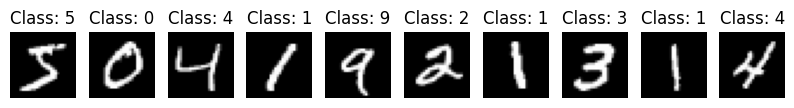

In [14]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## Linear model

Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product.

Note, like before, we consider multiple examples at once. input_images is a matrix where each row is an example.

In [15]:
def linear_model(W, input_images):
    # f(x) = xW returns m-length vector, where m is the number of examples
    return numpy.dot(input_images, W)

Like last week, the loss is mean squared error (MSE):

$\large{MSE = \frac{1}{n} \sum_{i=1}^{n} (y - \hat{y})^{2}}$ 

In [16]:
def evaluate(W, input_images, true_labels):
    predicted_label = linear_model(W, input_images)
    MSE = numpy.mean((true_labels - predicted_label)**2) 
    return MSE

Update weights using gradient decent 
$\large{W = W - \eta \frac{\partial J(W)}{\partial W} }$,  where, $W$ is the network weight, $\eta$ is the learning rate and $J(W)$ is the objective function

In [17]:
def learn(input_images, true_labels, current_W, learning_rate=0.000001):
    # first we need dJW/dW where JW = MSE 
    n = input_images.shape[0] # get number of examples to average over
    label_predictions = linear_model(current_W, input_images)
    # calculate gradient: one entry per partial derivative for an entry in vector W
    dJW_dW = (2./n) * numpy.dot(input_images.transpose(), label_predictions - true_labels)
    # now we update W
    new_W = current_W - (learning_rate * dJW_dW)  # gradient update step
    return new_W

In practice, we usually don't use all of the training data to calculate each step. We use a random subset. This makes the steps faster and noisier. 

In [18]:
# At the moment we take the simple route and use a fixed subset. 
batch_size = 100

x_train_batch = x_train[:batch_size, :]
y_train_batch = y_train[:batch_size,numpy.newaxis]

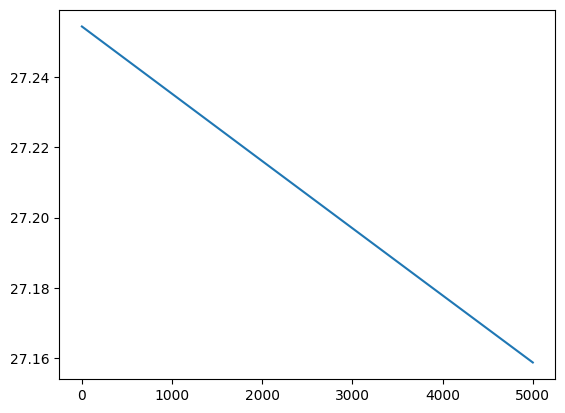

In [19]:
num_features = x_train.shape[1] # this is the number of pixels

# Randomly initialize W
W = .01 * numpy.random.rand(num_features,1)

# now iterate num_iters times, with the step size defined by learning_rate
learning_rate = 0.0005  
num_iters = 5000
losses = numpy.zeros(num_iters,)

for i in range(0, num_iters):
    # all the magic here
    W = learn(x_train_batch, y_train_batch, W, learning_rate)
    losses[i] = evaluate(W, x_train_batch, y_train_batch)
plt.plot(losses)

### Check results so far

As expected, this simple linear model f(x) = xW is not very accurate

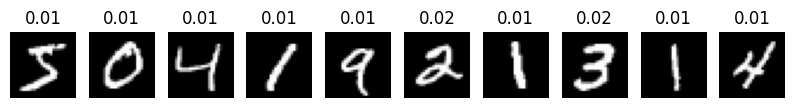

In [20]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
predicted_labels = linear_model(W, x_train[:10,:])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('%1.2f' % predicted_labels[i])

## In-class exercise: implement "accuracy" - number of images correctly labeled

## A solution:

In [21]:
# one answer, following the format of the above evaluate function:

def accuracy(true_labels, predicted_labels):
    N = predicted_labels.shape[0]
    acc = (true_labels == predicted_labels).sum() / N
    return acc

def evaluate_accuracy(W, input_images, true_labels):
    predicted_labels = numpy.round(linear_model(W, input_images)) # round real numbers to integer labels
    acc = accuracy(true_labels, predicted_labels) 
    return acc

In [22]:
# can plot this definition of accuracy here to check that it looks reasonable

# Randomly initialize W
W = .01 * numpy.random.rand(num_features,1)

# now iterate num_iters times, with the step size defined by learning_rate
losses = numpy.zeros(num_iters,)
accuracies = numpy.zeros(num_iters,)

for i in range(0, num_iters):
    # all the magic here
    W = learn(x_train_batch, y_train_batch, W, learning_rate)
    losses[i] = evaluate(W, x_train_batch, y_train_batch)
    accuracies[i] = evaluate_accuracy(W, x_train_batch, y_train_batch)


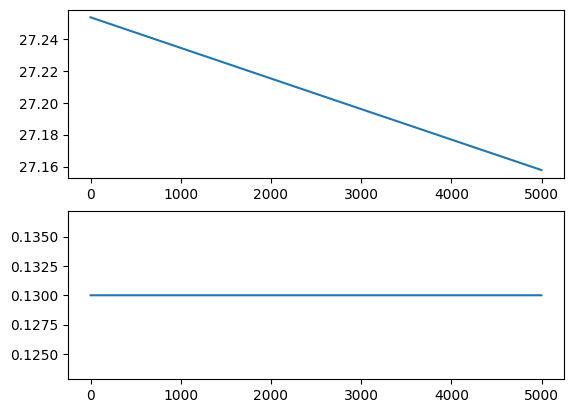

In [23]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses)
plt.subplot(2,1,2)
plt.plot(accuracies)

### Improving the model

Examples of basic ways to improve:
- Add bias term: f(x) = xW + b 
- Reformulate as classification (output integers, not real numbers), like logistic regression
- Minimize something other than mean squared error

The sigmoid function encourages outputs of 0 and 1

In [24]:
def sigmoid(x):
    z = 1/(1 + numpy.exp(-x))
    return(z)

def classification_model(A, b, input_images):
    # f(x) = sigmoid(xA + b) returns m-length vector, where m is the number of examples
    return sigmoid(numpy.dot(input_images, W) + b)

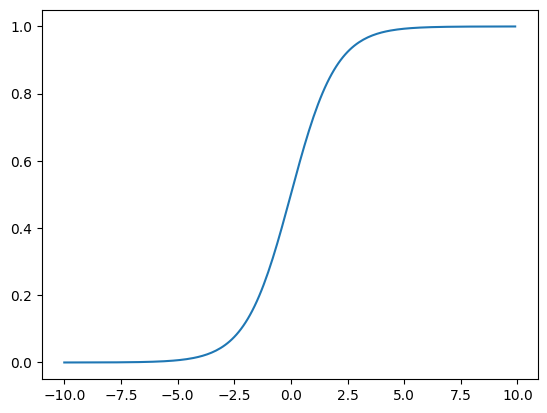

In [25]:
x = numpy.arange(-10, 10, step=.1)
plt.plot(x, sigmoid(x))

To handle multiple classes, it's common to use a one-hot encoding:

In [27]:
# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

Training sample 0 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Training sample 1 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 2 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Training sample 3 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 4 : class: 9 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Training sample 5 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 6 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 7 : class: 3 , one-hot encoded: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training sample 8 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 9 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


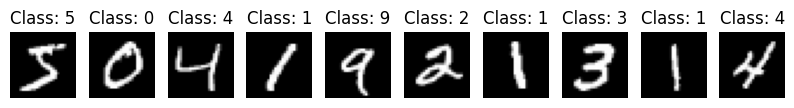

In [28]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(x_train[i,:], (28, 28)), cmap="gray")
    plt.title('Class: '+str(y_train[i]))
    print('Training sample',i,': class:',y_train[i], ', one-hot encoded:', y_train_onehot[i])

To handle multi-class classification, it's common to use softmax instead of sigmoid. It's related but forces the outputs to sum to 1, like a probability distribution. The class with the highest value is the prediction.

In [29]:
def softmax(x):
    normalization = numpy.sum(numpy.exp(x),axis=1)
    z = numpy.exp(x) / normalization[:,None]
    return(z)

In [30]:
# Randomly initialize W and b
W = .01 * numpy.random.rand(num_features,10)
b = .01 * numpy.random.rand(10,)

def classification_model(W, b, input_images):
    # f(x) = softmax(xW + b) returns m x 10 matrix, where m is the number of examples and 10 is the number of classes
    return softmax(numpy.dot(input_images, W) + b)

In [31]:
# To demonstrate softmax, we can apply this model with random W & b
predicted_labels = classification_model(W, b, x_train[:5,:])

In [32]:
# Here the class "probabilities" might all be very similar since the model hasn't been trained
print(predicted_labels[0,:])
print(sum(predicted_labels[0,:]))

[0.10010687 0.09972973 0.09979817 0.1000408  0.1004057  0.09962614
 0.09968953 0.10037435 0.0999554  0.10027331]
1.0000000000000002


Also, for multi-class classification problem, it is common to minimize a different "loss" function instead of mean squared error, like categorical cross-entropy. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

## Nonlinear Model

The above improvements are not enough to classify these images. We move to a nonlinear model. 

A neural network has multiple layers. A basic layer is $\sigma(xA + b)$, where $\sigma$ is a nonlinear "activation function." An example neural network with two layers adds another affine transformation:

$f(x) = \sigma(\sigma(xW_1 + b_1)W_2 + b_2)$

This is often drawn as a network like this:


<img src="images/tiny_network.png" width="300" hight="300" align="left"/>

Writing it in numpy, with sigmoid as the activation function:

In [33]:
def nonlinear_model(W1, W2, b1, b2, input_images):
    return sigmoid(numpy.dot(sigmoid(numpy.dot(input_images, W1) + b1), W2) + b2)

Adding another layer:

$f(x) = \sigma(\sigma(\sigma(xW_1 + b_1)W_2 + b_2)W_3 + b_3)$


<img src="images/three_layer_network.png" width="300" hight="300" align="left"/>

In [34]:
def nonlinear_model(A1, A2, A3, b1, b2, b3, input_images):
    return sigmoid(numpy.dot(sigmoid(numpy.dot(sigmoid(numpy.dot(input_images, A1) + b1), A2) + b2), A3) + b3)

We will learn about other activation functions (nonlinearities) next week.

Optimizing a nonlinear model: 
- We still want to use stochastic gradient descent (or a variant), but now the gradients are more complicated
- The gradients can be calculated with calculus (chain rule!). To save on computation, we move backward through the layers, saving intermediate results for re-use. This is called **back-propagation**.
- Applying the current network to the data is often called the "forward pass," and calculating the gradients is called the "backward pass."

Nonlinear neural networks can fit more complicated data than linear models. On the other hand, deep learning training can be tricky. 

1. Unlike linear regression, the objective function that you're minimizing (some measure of error) is non-convex, so there can be many local optima. As we learned about last week, the learning rate can help you jump into a new area, although too much jumping can be bad. 

![multiple local minima](images/nonconvex.png)

Image source: [firsttimeprogrammer.blogspot.com](http://firsttimeprogrammer.blogspot.com/2014/09/multivariable-gradient-descent.html)

There are some fancier versions of gradient descent optimization algorithms that are more effective, such as:
- Adam 
- RMSprop
- Adadelta
- Adagrad

For far more information, and some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/. It will be easier to try them out next week when we are using TensorFlow.

2. Neural networks can be overly flexible/complicated and "overfit" your data. This is like what happens if you fit a high-degree polynomial:


<img src="images/bias_vs_variance.png" width="800" hight="500" align="left"/>

3. To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models. Next week, we'll learn about Dropout for regularization. A simpler form is to add a penalty for large weights ("L2 regularization").


<img src="images/test_data_rule.png" width="800" hight="500" align="left"/>

## In-class exercise: split the training data into training & validation, and track validation loss during the training loop. 

Tip: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

How do we know when to stop training? For example, you might stop when the validation loss stops improving.

## A solution:

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

In [37]:
# for simplicity and speed, we could again consider just a batch of training data & a batch of validation data
x_train_batch2 = x_train2[:batch_size, :]
y_train_batch2 = y_train2[:batch_size,numpy.newaxis]
x_val_batch = x_val[:batch_size, :]
y_val_batch = y_val[:batch_size,numpy.newaxis]

In [38]:
# Randomly initialize W
W = .01 * numpy.random.rand(num_features,1)

# now iterate num_iters times, with the step size defined by learning_rate
losses = numpy.zeros((num_iters,2)) # 1st column for training data, 2nd for validation data
accuracies = numpy.zeros((num_iters,2))

for i in range(0, num_iters):
    W = learn(x_train_batch2, y_train_batch2, W, learning_rate)
    losses[i,0] = evaluate(W, x_train_batch, y_train_batch)
    losses[i,1] = evaluate(W, x_val_batch, y_val_batch)
    accuracies[i,0] = evaluate_accuracy(W, x_train_batch2, y_train_batch2)
    accuracies[i,1] = evaluate_accuracy(W, x_val_batch, y_val_batch)

## By plotting both training and validation loss/accuracy, we see definite overfitting

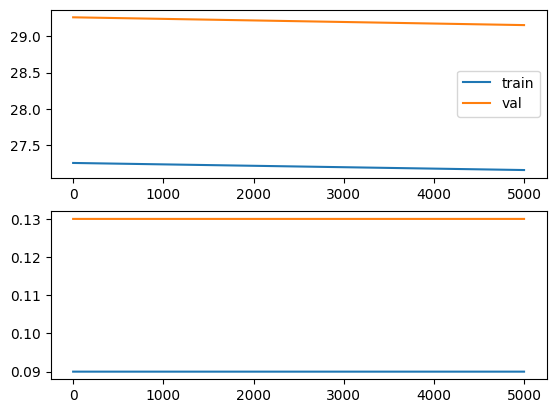

In [39]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

Now that we have the basics, we can experiment with more complicated networks. Rather than implement these all by hand, we will move to using existing Python packages next week. 

There are variants of "universal approximation theorems" roughly stating that there exists a nonlinear neural network with one hidden layer (possibly very wide) can fit an "arbitrary" nice/smooth function arbitrarily well. However, we can make the optimizaiton easier with fancier layers than "fully connected," like convolutional layers, which we will learn about next week. 

In [41]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
mnist_path = "mnist.npz"
with np.load(mnist_path, allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

# Normalize the pixel values to be within 0 to 1
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Reshape the images from 28x28 to flat vectors of size 784
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Print the shapes of the datasets
print("Training images shape:", x_train.shape)
print("Test images shape:", x_test.shape)

# Convert labels to one-hot encoded format
num_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

# Print the shapes of the labels
print("Training labels shape:", y_train_onehot.shape)
print("Test labels shape:", y_test_onehot.shape)


Training images shape: (60000, 784)
Test images shape: (10000, 784)
Training labels shape: (60000, 10)
Test labels shape: (10000, 10)


In [42]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet


In [43]:
num_features = x_train.shape[1] # this is the number of pixels
# The weights are initialized from a normal distribution with standard deviation weight_scale
model = TwoLayerNet(input_dim=num_features, hidden_dim=300, num_classes=nb_classes, weight_scale=.01)


In [44]:
# here you can take a look if you want at the initial loss from an untrained network
loss, gradients = model.loss(x_train, y_train_onehot)


In [45]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights
    return model


In [47]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    model = sgd(model, gradients, learning_rate)
    return loss, model


In [49]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    acc = (true_values == predictions).sum() / N
    return acc


epoch 0, loss 2.30278, accuracy 0.09
epoch 1, loss 2.30090, accuracy 0.11
epoch 2, loss 2.29948, accuracy 0.13
epoch 3, loss 2.29770, accuracy 0.15
epoch 4, loss 2.29612, accuracy 0.18
epoch 5, loss 2.29442, accuracy 0.22
epoch 6, loss 2.29265, accuracy 0.26
epoch 7, loss 2.29111, accuracy 0.30
epoch 8, loss 2.28961, accuracy 0.34
epoch 9, loss 2.28766, accuracy 0.37


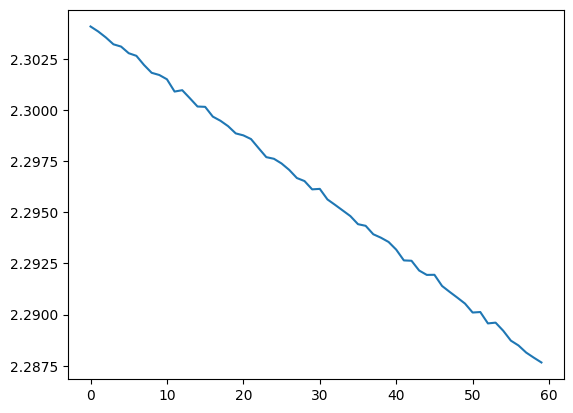

In [50]:
# Here's an example training loop using this two-layer model. Can you do better? 
learning_rate = 0.01  
num_examples = x_train.shape[0]
batch_size = 10000
num_batches = int(num_examples / batch_size)
num_epochs = 10
losses = numpy.zeros(num_batches*num_epochs,)
indices = numpy.arange(num_examples)

i = 0
for epoch in range(0, num_epochs):
    # in each epoch, we loop over all of the training examples
    for step in range(0, num_batches):
        # grabbing the next batch
        offset = step * batch_size
        batch_range = range(offset, offset+batch_size)
        x_train_batch = x_train[batch_range, :]
        y_train_batch = y_train_onehot[batch_range,:]
        
        # feed the next batch in to do one sgd step
        loss, model = learn(model, x_train_batch, y_train_batch, learning_rate)
        losses[i] = loss
        i += 1

    acc = accuracy(model, x_train, y_train)
    print("epoch %d, loss %.5f, accuracy %.2f" % (epoch, loss, acc))
    
    # reshuffle the data so that we get a new set of batches
    numpy.random.shuffle(indices)
    x_train = x_train[indices,:]
    y_train = y_train[indices] # keep this shuffled the same way for use in accuracy calculation
    y_train_onehot = y_train_onehot[indices,:]
plt.plot(losses)

In [51]:
accuracy(model, x_train, y_train)


0.37478333333333336

# Homework: improve the accuracy of this model. 

Update this notebook so that the accuracy is improved. How high can you get it? You could change things directly in the notebook, such as increasing the number of epochs, changing the learning weight, changing the width of the hidden layer, etc. If you're more ambitious, you could also try changing the model definition itself by checking out the associated Python files. For example, you could add more layers to the network. The current notebook has a training accuracy of about 43%, but will vary with randomness.

In [54]:
# Adjusting hyperparameters
learning_rate = 0.001  # Decreasing the learning rate
num_epochs = 20  # Increasing the number of epochs
hidden_dim = 512  # Increasing the width of the hidden layer

# Reinitializing the model with updated hyperparameters
model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=num_classes, weight_scale=.01)

# Calculate the total number of iterations
total_iterations = num_epochs * num_batches

# Initialize losses array
losses = numpy.zeros(total_iterations,)

# Training the model with the updated hyperparameters
i = 0  # Initialize the index counter for losses array
for epoch in range(0, num_epochs):
    for step in range(0, num_batches):
        offset = step * batch_size
        batch_range = range(offset, offset+batch_size)
        x_train_batch = x_train[batch_range, :]
        y_train_batch = y_train_onehot[batch_range,:]
        loss, model = learn(model, x_train_batch, y_train_batch, learning_rate)
        losses[i] = loss
        i += 1

    acc = accuracy(model, x_train, y_train)
    print("epoch %d, loss %.5f, accuracy %.2f" % (epoch, loss, acc))

    numpy.random.shuffle(indices)
    x_train = x_train[indices,:]
    y_train = y_train[indices]
    y_train_onehot = y_train_onehot[indices,:]


epoch 0, loss 2.30548, accuracy 0.06
epoch 1, loss 2.30517, accuracy 0.07
epoch 2, loss 2.30456, accuracy 0.07
epoch 3, loss 2.30433, accuracy 0.07
epoch 4, loss 2.30432, accuracy 0.07
epoch 5, loss 2.30383, accuracy 0.07
epoch 6, loss 2.30369, accuracy 0.07
epoch 7, loss 2.30331, accuracy 0.07
epoch 8, loss 2.30295, accuracy 0.08
epoch 9, loss 2.30273, accuracy 0.08
epoch 10, loss 2.30234, accuracy 0.08
epoch 11, loss 2.30222, accuracy 0.08
epoch 12, loss 2.30207, accuracy 0.09
epoch 13, loss 2.30193, accuracy 0.09
epoch 14, loss 2.30133, accuracy 0.09
epoch 15, loss 2.30119, accuracy 0.09
epoch 16, loss 2.30099, accuracy 0.10
epoch 17, loss 2.30073, accuracy 0.10
epoch 18, loss 2.30044, accuracy 0.10
epoch 19, loss 2.30014, accuracy 0.11
